# Project 3 - Recommender Systems

#### Library imports

In [300]:
import pandas as pd
import numpy as np
import random 

import matplotlib.pyplot as plt
import seaborn as sns

from surprise.model_selection.validation import cross_validate
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD
from surprise import Reader, Dataset
from surprise.model_selection import KFold
from surprise import accuracy
from surprise.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
rand_seed = 42
np.random.seed(rand_seed)
random.seed(rand_seed)

## 3. Dataset

#### Data Exploration

In [87]:
folder_name = 'Synthetic_Movie_Lens/'
ratings_raw = pd.read_csv(folder_name+'ratings.csv', index_col=0)
movies = pd.read_csv(folder_name+'movies.csv')

In [181]:
print(len(ratings_raw))
ratings_raw.head(5)

100836


,userId,movieId,rating,timestamp
0,496,112852,3.0,1415520462
1,391,1947,4.0,1030945141
2,387,1562,1.5,1095041022
3,474,2716,4.5,1053020930
4,483,88125,4.5,1311337237


In [6]:
movie.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings_mat_df = ratings_raw.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)
ratings_mat_df

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.5,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0,0.0,4.0,...,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0


In [8]:
print(f'Number of users: {ratings_mat_df.shape[0]}')
print(f'Number of movies: {ratings_mat_df.shape[1]}')

Number of users: 610
Number of movies: 9724


### Question 1


#### Question 1.A

Computethe sparsity of the movie rating dataset:

Sparsity = Total number of available ratings / Total number of possible ratings


In [9]:
total_ratings = sum(ratings_mat_df.astype(bool).sum(axis=0))
total_possible_ratings = ratings_mat_df.shape[0]*ratings_mat_df.shape[1]
sparsity = total_ratings/total_possible_ratings

print(f'Total num of available ratings: {total_ratings}' )
print(f'Total num of possible ratings: {total_possible_ratings}' )
print(f'Sparsity: {sparsity}' )

Total num of available ratings: 100836
Total num of possible ratings: 5931640
Sparsity: 0.016999683055613623


#### Question 1.B

Plot a histogram showing the frequency of the rating values: Bin the raw rating values into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the number of entries in the ratings matrix R that fall within each bin and use this count as the height of the vertical axis for that particular bin. Comment on the shape of the histogram.

In [10]:
# Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).
sorted(ratings_raw.rating.unique())

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

Text(0, 0.5, 'Number of Ratings')

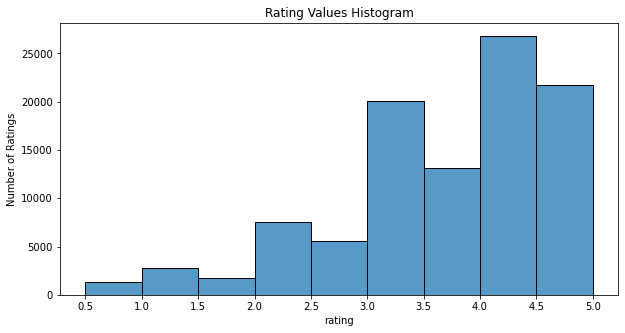

In [11]:
bins_range = sorted(ratings_raw.rating.unique())
plt.figure(figsize=(10,5))
g = sns.histplot(data=ratings_raw, x="rating", bins=bins_range)
#g.set(xticklabels=bins_range)
plt.xticks(bins_range)
plt.title('Rating Values Histogram')
plt.ylabel('Number of Ratings')

The ratings are within the 0.5 to 5.0 range. Users who gave ratings tends to give higher rating scores since the trend of the histogram is towards the higher ratings. Around 81% of the ratings are 3 and above and 21.5% is 4.5 and above. One possible interpretation is that users may tend to give ratings to the movies they like or they liked the movies they watched.


In [12]:
print(ratings_raw.rating.value_counts(sort=True))
print(ratings_raw.rating.value_counts(sort=True, normalize=True))

4.0    26816
3.0    20046
5.0    13211
3.5    13136
4.5     8553
2.0     7551
2.5     5551
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64
4.0    0.265937
3.0    0.198798
5.0    0.131015
3.5    0.130271
4.5    0.084821
2.0    0.074884
2.5    0.055050
1.0    0.027877
1.5    0.017762
0.5    0.013586
Name: rating, dtype: float64


#### Question 1.C

Plot the distribution of the number of ratings received among movies: The X-axis should be the movie index ordered by decreasing frequency and the Y -axis should be the number of ratings the movie has received; ties can broken in any way. A monotonically decreasing trend is expected.

In [13]:
rating_count_per_movie = pd.DataFrame(ratings_raw.groupby(by='movieId').rating.count().sort_values(ascending=False))
rating_count_per_movie.reset_index(inplace=True)
rating_count_per_movie

,movieId,rating
0,356,329
1,318,317
2,296,307
3,593,279
4,2571,278
...,...,...
9719,57502,1
9720,57522,1
9721,57526,1
9722,4032,1


Text(0, 0.5, 'Number of Ratings')

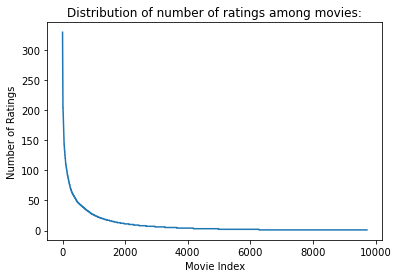

In [14]:
plt.plot(rating_count_per_movie.rating.values)
plt.title('Distribution of number of ratings among movies:')
plt.xlabel('Movie Index')
plt.ylabel('Number of Ratings')

In [15]:
rating_count_per_movie.describe().T

,count,mean,std,min,25%,50%,75%,max
movieId,9724.0,42245.024373,52191.137320,1.0,3245.5,7300.0,76739.25,193609.0
rating,9724.0,10.369807,22.401005,1.0,1.0,3.0,9.00,329.0


In [16]:
rating_count_per_movie.rating.value_counts(normalize=True)

1      0.354381
2      0.133484
3      0.082271
4      0.054504
5      0.039284
         ...   
203    0.000103
211    0.000103
251    0.000103
215    0.000103
307    0.000103
Name: rating, Length: 177, dtype: float64

As expected we observe a monotonically decreasing trend. Majority of the movies rated very few or 1 times.

#### Question 1.D

Plot the distribution of ratings among users: The X-axis should be the user index ordered by decreasing frequency and the Y -axis should be the number of movies the user has rated. The requirement of the plot is similar to that in Question C.

In [17]:
rating_count_per_user = pd.DataFrame(ratings_raw.groupby(by='userId').rating.count().sort_values(ascending=False))
rating_count_per_user.reset_index(inplace=True)
rating_count_per_user

,userId,rating
0,414,2698
1,599,2478
2,474,2108
3,448,1864
4,274,1346
...,...,...
605,569,20
606,194,20
607,147,20
608,406,20


Text(0, 0.5, 'Number of Ratings')

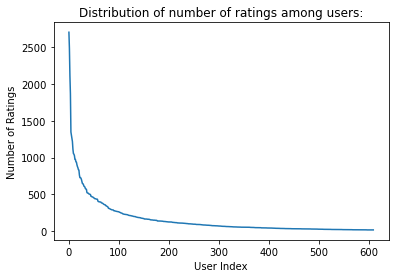

In [18]:
plt.plot(rating_count_per_user.rating.values)
plt.title('Distribution of number of ratings among users:')
plt.xlabel('User Index')
plt.ylabel('Number of Ratings')

In [19]:
rating_count_per_user.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,610.0,305.500000,176.236111,1.0,153.25,305.5,457.75,610.0
rating,610.0,165.304918,269.480584,20.0,35.00,70.5,168.00,2698.0


In [20]:
rating_count_per_user.rating.value_counts(normalize=True).sort_index()

20      0.022951
21      0.024590
22      0.022951
23      0.021311
24      0.011475
          ...   
1346    0.001639
1864    0.001639
2108    0.001639
2478    0.001639
2698    0.001639
Name: rating, Length: 261, dtype: float64

In [21]:
rating_count_per_user.rating.value_counts(normalize=True).sort_index().cumsum().head(51)

20    0.022951
21    0.047541
22    0.070492
23    0.091803
24    0.103279
25    0.118033
26    0.139344
27    0.152459
28    0.165574
29    0.178689
30    0.183607
31    0.195082
32    0.206557
33    0.222951
34    0.237705
35    0.255738
36    0.270492
37    0.280328
38    0.291803
39    0.298361
40    0.308197
41    0.314754
42    0.322951
43    0.327869
44    0.332787
45    0.342623
46    0.350820
47    0.357377
48    0.368852
50    0.380328
51    0.388525
52    0.391803
53    0.398361
54    0.403279
55    0.406557
56    0.429508
57    0.436066
58    0.444262
59    0.449180
60    0.452459
61    0.460656
62    0.463934
63    0.465574
64    0.473770
65    0.480328
66    0.483607
67    0.486885
68    0.488525
69    0.496721
70    0.500000
71    0.501639
Name: rating, dtype: float64

Again we see a decreasing trend with a tailed curve. There are some users who did a lot of ratings but majority seems to did low number of ratings. The minimum number of ratings among the users is 20. 

#### Question 1.E

Discuss the salient features of the distributions from Questions C,D and their implications for the recommendation process.

In 1.C, the number of ratings given to movies has a monotonically decreasing trend with a long tail on the right. This means majority of the movies get very low number of ratings where few of the movies get majority of the ratings. Around 35.4% movies get only 1 rating. Similarly, in 1.D, the number of ratings given by users has a monotonically decreasing trend with a long tail as well. This means majority of the users gave few ratings, and there are few users with very high number of ratings. Half of the users gave at least 20 and at most 70 movie ratings. Given that we have 610 users and 9724 movies, the ratings matrix R is a sparse matrix. The sparsity wee calculate in Q1.A with 0.0169 confirms this. Having a sparse matrix makes recommendation systems job harder, as there are few links between users and movies. Given the sparsity of matrix finding the similarities between users or movies will be challenging because we will have to work on small number of ratings, given that majority of the values are 0. 

TODO add regularization oage 6 descrip

#### Question 1.F

Compute the variance of the rating values received by each movie: Bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the resulting histogram.
 

In [22]:
rating_count_per_movie_var = pd.DataFrame(ratings_raw.groupby(by='movieId').agg(max_rating=('rating', 'max'), min_rating=('rating', 'min'), rating_variance=('rating', 'var'), rating_count=('rating', 'count'), rating_mean=('rating', 'mean'))).reset_index()
rating_count_per_movie_var.head(30).T


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
movieId,1.00000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000,10.000000,...,21.000000,22.000000,23.000,24.000000,25.0000,26.000,27.000000,28.000000,29.000000,30.0
max_rating,5.00000,5.000000,5.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000,5.000000,...,5.000000,5.000000,5.000,5.000000,5.0000,4.000,5.000000,5.000000,5.000000,4.0
min_rating,0.50000,0.500000,0.500000,1.000000,0.500000,1.000000,1.000000,1.000000,1.500,0.500000,...,1.000000,1.000000,1.000,1.000000,1.0000,2.500,2.000000,2.500000,2.000000,1.0
rating_variance,0.69699,0.777419,1.112651,0.726190,0.822917,0.670841,0.955625,1.267857,0.950,0.738535,...,0.752809,0.677778,1.250,1.030093,1.2475,0.375,1.437500,0.618182,0.682255,3.0
rating_count,215.00000,110.000000,52.000000,7.000000,49.000000,102.000000,54.000000,8.000000,16.000,132.000000,...,89.000000,36.000000,16.000,28.000000,76.0000,13.000,9.000000,11.000000,38.000000,3.0
rating_mean,3.92093,3.431818,3.259615,2.357143,3.071429,3.950980,3.185185,2.875000,3.125,3.496212,...,3.494382,3.222222,3.125,3.125000,3.6250,3.500,3.333333,4.227273,4.013158,3.0


In [23]:
rating_count_per_movie_var.describe()

,movieId,max_rating,min_rating,rating_variance,rating_count,rating_mean
count,9724.000000,9724.000000,9724.000000,6278.000000,9724.000000,9724.000000
mean,42245.024373,3.912999,2.416495,0.857169,10.369807,3.262448
std,52191.137320,1.056532,1.241600,0.795839,22.401005,0.869874
min,1.000000,0.500000,0.500000,0.000000,1.000000,0.500000
25%,3245.500000,3.500000,1.500000,0.395833,1.000000,2.800000
50%,7300.000000,4.000000,2.500000,0.702111,3.000000,3.416667
75%,76739.250000,5.000000,3.500000,1.105310,9.000000,3.911765
max,193609.000000,5.000000,5.000000,10.125000,329.000000,5.000000


[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]


Text(0.5, 1.0, 'Histogram of Rating Values Variance per movie')

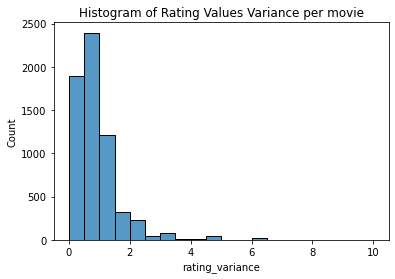

In [24]:
bin_vals = np.arange(rating_count_per_movie_var.rating_variance.min(), rating_count_per_movie_var.rating_variance.max(),0.5)
print(bin_vals)
sns.histplot(data=rating_count_per_movie_var, x="rating_variance", bins=bin_vals)
plt.title('Histogram of Rating Values Variance per movie')

In [25]:
rating_count_per_movie_var.rating_variance.value_counts()

0.500000    353
0.125000    345
0.000000    298
1.125000    182
2.000000    129
           ... 
0.773958      1
1.118577      1
1.725000      1
0.618182      1
1.055556      1
Name: rating_variance, Length: 2841, dtype: int64

I used unbiased estimator.

</color=red> TODO comment on the resulting shape
explained diff btw biased vs unbiased histogram

## 4 Neighborhood-based collaborative filtering

### Question 2

#### Question 2.A

Write down the formula for $μ_u$ in terms of $I_u$ and $r_{uk}$


 $$ \mu_u = \frac{\text{Sum of ratings given by user u}}{\text{Number of ratings given by user u}} $$
 
 
 $$  \mu_u = \frac{\sum_{k	\in I_u} r_{uk}}{|I_u|}    $$

#### Question 2.B

In plain words, explain the meaning of $I_u ∩ I_v$. Can $ I_u ∩ I_v = ∅$ ? (Hint: Rating matrix R is sparse)

$I_u ∩ I_v$ are the set of movies where both user u and user v rated. Because R matrix is sparse, it is very likely that for some user u and user v, they don't have any common movies they rated, hence the intersection of them is empty ($ I_u ∩ I_v = ∅$).

### Question 3

Understanding the Prediction function: Can you explain the reason behind mean-centering the raw ratings $(r_{vj} − μ_v)$ in the prediction function? (Hint: Consider users who either rate all items highly or rate all items poorly and the impact of these users on the prediction function.)

 Ratings can be subjective for every person, some people might be more prone to give higher scores and some prone to give lower scores. Therefore, score distribution of users also could be very different. We are not interested in the absolute rating for a movie from a user, because let's say an average rating for user A is 4 and he gave a movie rating 2.5 to movie X, thinks movie is bad, and user B has an average rating of 2. Then when we try to predict User B's rating, if we use absolute score, user B will think like user A liked the movie (user B's avg was 2) and become prone to like movie X. If both users have similar tastes, B should have dislike the movie as well. 

To reduce subjectivity and bias, we should interpret the score given by users relatively rather than absolute rating, and standardize them. Otherwise we might end up misinterpreting the score. To standardize user ratings we do mean centering around each user. In this way, mean centering can reduce the user bias, and help us predict more accurate and unbiased rating scores.

### Question 4

Design a k-NN collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).


In [26]:
reader = Reader(rating_scale=(0.5, 5))
ratings_data = Dataset.load_from_df(ratings_raw[['userId', 'movieId', 'rating']], reader)

In [277]:
def evaluate_model(data, model_type, k_range, plot_dets, is_plot=True, print_update=False):
    avg_rmse, avg_mae = [], []
    cv_results_list = []
    for i, k in enumerate(k_range):
        if i % 10==0 and print_update:
            print(f'{i} / {len(k_range)} -- k: {k}')
        
        model = get_model(model_type=model_type, k=k)
        cv_results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
        cv_results_list.append(cv_results)
        avg_rmse.append(np.mean(cv_results['test_rmse']))
        avg_mae.append(np.mean(cv_results['test_mae']))
        
    if is_plot: 
        plot_evaluation_metric(x= k_range, 
                               ys=[avg_rmse],
                               x_label=plot_dets['x_label'],
                               y_label='Average RMSE accross 10-fold CV',
                               title=plot_dets['title'], 
                               labels=['Average RMSE'])
        plot_evaluation_metric(x= k_range, 
                               ys=[avg_mae],
                               x_label=plot_dets['x_label'],
                               y_label='Avergae MAE accross 10-fold CV',
                               title=plot_dets['title'], 
                               labels=['Average MAE'])
        res_pdf = pd.DataFrame({'k': k_range, 'avg_rmse':avg_rmse, 'avg_mae':avg_mae, 'cv_results':cv_results_list })
        return res_pdf

def plot_evaluation_metric(x, ys, x_label, y_label, title, labels,  fig_size=(10,7)):
    colors = ['blue','green','orange','purple']
    plt.figure(figsize=fig_size)
    for i, y in enumerate(ys):
        plt.plot(x, y, label = labels[i], color=colors[i])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.show()
    
def get_model(model_type, k):
    model = None
    if model_type == 'KNN':
        model = KNNWithMeans(k=k, sim_options = {'name':'pearson', 'user_based':True}, verbose=0) 
    elif model_type == 'NMF':
        model = NMF(n_factors=k, random_state=rand_seed, verbose=0)
    elif model_type == 'MF':
        model = SVD(n_factors=k, random_state=rand_seed, verbose=0)
    else: 
        raise 'Wrong trim type: select from popular, unpopular or high_variance'
        
    return model

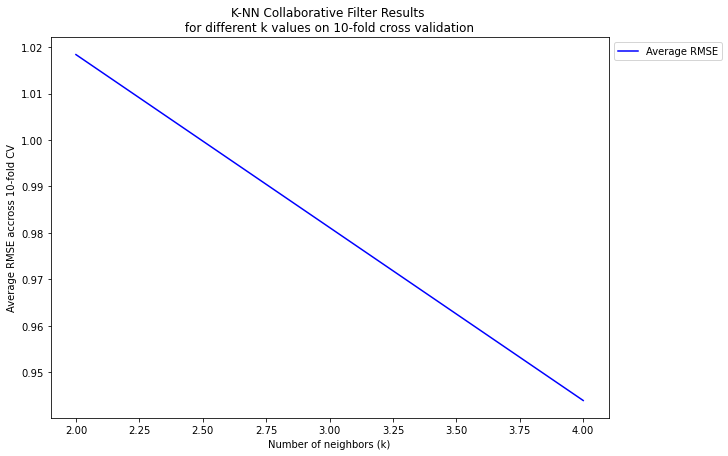

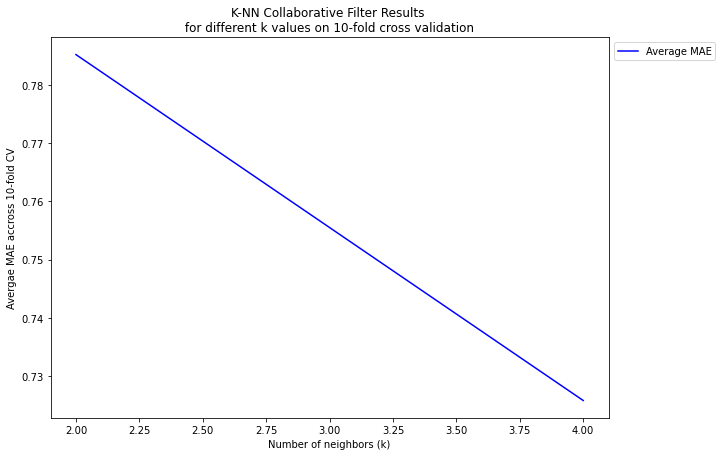

In [31]:
plot_dets_q4 = {
    'x_label': 'Number of neighbors (k)',
    'y_label': 'Average Test Error accross 10-fold CV',
    'title': 'K-NN Collaborative Filter Results \n for different k values on 10-fold cross validation '
}
k_range_q4 = list(range(2, 5, 2))   # to do change range to 100
q4_exp_df = evaluate_model(data=ratings_data, model_type='knn', k_range=k_range_q4, plot_dets=plot_dets_q4)

In [75]:
q4_exp_df.T.head(20)

,0,1
k,2,4
avg_rmse,1.0184,0.943863
avg_mae,0.785199,0.725791
cv_results,"{'test_rmse': [1.0064455149967226, 1.031740256...","{'test_rmse': [0.9361455127443382, 0.936461550..."


### Question 5

Use the plot from question 4, to find a ’minimum k’. Note: The term ’minimum k’ in this context means that increasing k above the minimum value would not result in a significant decrease in average RMSE or average MAE. If you get the plot correct, then ’minimum k’ would correspond to the k value for which average RMSE and average MAE converges to a steady-state value. Please report the steady state values of average RMSE and average MAE.

In [35]:
q4_exp_df[['k','avg_rmse','avg_mae']]

,k,avg_rmse,avg_mae
0,2,1.018401,0.785199
1,4,0.943863,0.725791


In [36]:
# TODO answer question

### Question 6

In [37]:
popular_movies = rating_count_per_movie_var[rating_count_per_movie_var.rating_count > 2].movieId.values
unpopular_movies = rating_count_per_movie_var[rating_count_per_movie_var.rating_count <= 2].movieId.values
high_var_movies = rating_count_per_movie_var[(rating_count_per_movie_var.rating_count >= 5) & (rating_count_per_movie_var.rating_variance >= 2)].movieId.values

print(f'Number of popular movies: {len(popular_movies)}')
print(f'Number of unpopular movies: {len(unpopular_movies)}')
print(f'Number of high variance movies: {len(high_var_movies)}')

Number of popular movies: 4980
Number of unpopular movies: 4744
Number of high variance movies: 87


#### Methods

In [41]:
def clean_based_on_trim_type(data, trim_type):
    trimmed_data = None
    if trim_type == 'popular':
        trimmed_data = trim_popular(data)
    elif trim_type == 'unpopular':
        trimmed_data = trim_unpopular(data)
    elif trim_type == 'high_variance':
        trimmed_data = trim_high_variance(data)
    else: 
        raise 'Wrong trim type: select from popular, unpopular or high_variance'
    return trimmed_data

def trim_popular(data):
    trimmed_data = [x for x in data if x[0] in popular_movies] 
    return trimmed_data

def trim_unpopular(data):
    trimmed_data = [x for x in data if x[0] in unpopular_movies] 
    return trimmed_data

def trim_high_variance(data):    
    trimmed_data = [x for x in data if x[0] in high_var_movies] 
    return trimmed_data

In [71]:
def evaluate_model_on_trimsets(data, model_type, k_range, plot_dets, trim_types, is_plot=True, print_update=False):
 
    kf = KFold(n_splits=10)
    all_rmses, all_maes, res_dfs = [],[], []
    for trim_type in trim_types:
        avg_rmse, avg_mae = [], []
        cv_results_dict = {}
        for i, k in enumerate(k_range):
            if i % 10==0 and print_update:
                    print(f'{i} / {len(k_range)} -- k: {k}')

            k_rmses, k_maes = [], []
            for train_data, test_data in kf.split(data):
                model = get_model(model_type=model_type, k=k) 
                model.fit(train_data)

                # clean test set based on trim type (popular, unpopular, high variance)
                if not trim_type:
                    test_data_trimmed=test_data
                else:
                    test_data_trimmed = clean_based_on_trim_type(data=test_data, trim_type=trim_type)
                preds = model.test(test_data_trimmed)

                k_rmses.append(accuracy.rmse(preds, verbose=False))
                k_maes.append(accuracy.mae(preds, verbose=False))

            cv_results_dict[k]={'rmse_results':k_rmses, 'mae_results':k_maes}    
            avg_rmse.append(np.mean(k_rmses))
            avg_mae.append(np.mean(k_maes))
        trim_type_name = trim_type if trim_type else 'original'
        res_df = pd.DataFrame({'k': k_range, f'avg_rmse_{trim_type_name}':avg_rmse, f'avg_mae_{trim_type_name}':avg_mae}) #, 'cv_results':[cv_results_dict]})
        res_dfs.append(res_df)
        all_rmses.append(avg_rmse)
        all_maes.append(avg_mae)
         
    if is_plot: 
        title = f'K-NN Collaborative Filter Results \n for different test set and k values \n on 10-fold cross validation '
        trim_names = []
        for trim_type in trim_types:
            trim_name=None
            if not trim_type:
                trim_name = 'Original'
            elif trim_type=='high_variance':
                trim_name = 'High Variance'
            else:
                trim_name = trim_type.capitalize()
            trim_names.append(trim_name)
        plot_evaluation_metric(x= k_range, 
                               ys=all_rmses,
                               x_label=plot_dets['x_label'],
                               y_label='Average RMSE',
                               title=f'K-NN Collaborative Filter Results \n Avergae RMSE on 10-fold cross validation \n for different test set and k values', 
                               labels=[f'Average RMSE - {x} test set' for x in trim_names])
        plot_evaluation_metric(x= k_range, 
                               ys=all_maes,
                               x_label=plot_dets['x_label'],
                               y_label='Avergae MAE',
                               title=f'K-NN Collaborative Filter Results \n Avergae MAE on 10-fold cross validation \n for different test set and k values', 
                               labels=[f'Average MAE - {x} test set' for x in trim_names])
       
    return res_dfs
    

In [370]:
def plot_roc(fprs, tprs, thresholds, aucs, axs=None, title=''):
    lw = 2
    colors = ['green', 'orange','pink','blue']
    
    if not axs:
        plt.figure(figsize=(12,12))
    for i in range(len(thresholds)):
        if not axs:
            plt.scatter(
                fprs[i],
                tprs[i],
                color=colors[i],
                lw=lw,
                label=f"THR {thresholds[i]}:  AUC: {aucs[i]:.3f})",
            )
        else:
            axs.plot(
                fprs[i],
                tprs[i],
                color=colors[i],
                lw=lw,
                label=f"THR {thresholds[i]}:  AUC: {aucs[i]:.3f})",
            )
    if not axs:
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title("ROC Curve ")
        plt.legend(loc="lower right")
        plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
        plt.show()
    else:
        axs.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        axs.set_xlim([0.0, 1.0])
        axs.set_ylim([0.0, 1.05])
        axs.set(xlabel="False Positive Rate (FPR)", ylabel="True Positive Rate (TPR)")
        axs.set_title("ROC Curve "+title)
        axs.legend(loc="lower right")
    
def plot_roc_curves(data, model_type, trim_type, chosen_k, thresholds, axes=None):
    train_data, test_data = train_test_split(data, test_size=0.1)

    model = get_model(model_type=model_type, k=chosen_k)
    model.fit(train_data)
    if not trim_type:
        test_data_trimmed= test_data
    else:
        test_data_trimmed = clean_based_on_trim_type(data=test_data, trim_type=trim_type)
    preds = model.test(test_data_trimmed)
    aucs, fprs, tprs = [], [], []
           
    for thr in thresholds:

        preds_vals = [pred.est for pred in preds]
        #preds_vals_thresholded = [1 if pred.est > thr else 0 for pred in preds ]
        ground_truth_thresholded = [1 if pred.r_ui > thr else 0 for pred in preds ]

        fpr, tpr, ths = roc_curve(y_true=ground_truth_thresholded, y_score=preds_vals)
        fprs.append(fpr)
        tprs.append(tpr)
        roc_auc_score = auc(fpr, tpr)
        aucs.append(roc_auc_score)

    trim_name=None
    if not trim_type:
        trim_name = 'Original'
    elif trim_type=='high_variance':
        trim_name = 'High Variance'
    else:
        trim_name = trim_type.capitalize() 
    plot_roc(fprs=fprs, tprs=tprs, thresholds=thresholds, aucs=aucs, axs=axes, title=f'for {model_type.upper()} on {trim_name} test set')


def multiple_rocs(data, model_type, trim_types,  chosen_k, thresholds, suptitle=''):
    fig, axs = plt.subplots(2, 2, figsize=(12,12))
    indices = [(0,0), (0,1),(1,0), (1,1)]
    for idx, (i,j) in  enumerate(indices):
        plot_roc_curves(data, model_type, trim_types[idx], chosen_k, thresholds, axes=axs[i,j])
    plt.suptitle(suptitle)
    plt.show()

#### Results of KNN on Original Test set and Popular, Unpopular, High Variance Trimmed Test Sets

0 / 3 -- k: 2
0 / 3 -- k: 2
0 / 3 -- k: 2
0 / 3 -- k: 2


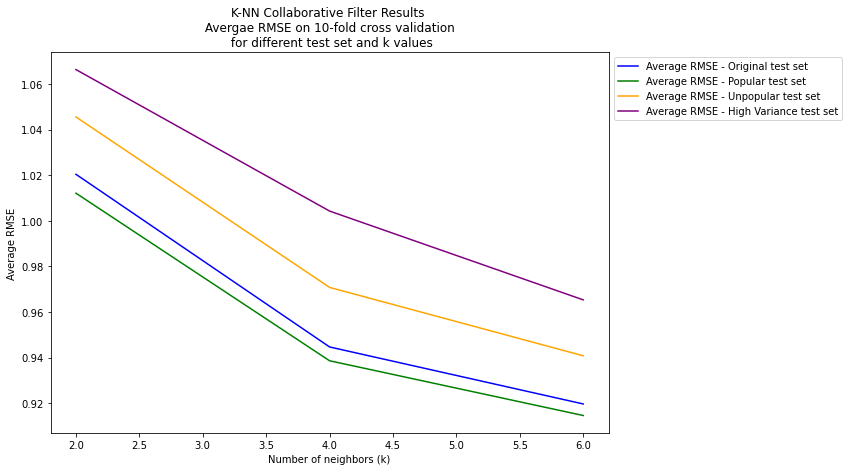

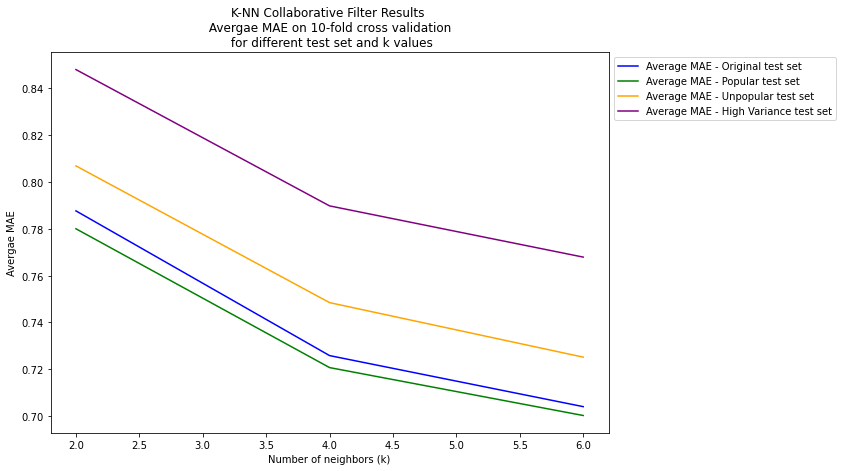

In [72]:
plot_dets_q6 = {
    'x_label': 'Number of neighbors (k)',
    'y_label': 'Average Test Error accross 10-fold CV'
}
k_range_q6 = list(range(2, 7, 2))  # to do change range to 100
q6_knn_res_dfs = evaluate_model_on_trimsets(data=ratings_data,
                                                   model_type='KNN',
                                                   k_range=k_range_q6, 
                                                   plot_dets=plot_dets_q6, 
                                                   trim_types = [None, 'popular','unpopular','high_variance'],
                                                   is_plot=True, 
                                                   print_update=True) #TODO make it false later

In [70]:
q6_knn_res_df = pd.concat(q6_knn_res_dfs)
q6_knn_res_df_pivot = q6_knn_res_df.pivot_table(columns='k').T
display(q6_knn_res_df_pivot.head(10))
display(q6_knn_res_df_pivot.describe())
print('Min Avg RMSE and Avg MAE for each test set:')
print(q6_knn_res_df_pivot.min())

,avg_mae_high_variance,avg_mae_original,avg_mae_popular,avg_mae_unpopular,avg_rmse_high_variance,avg_rmse_original,avg_rmse_popular,avg_rmse_unpopular
k,,,,,,,,
2,0.868735,0.784176,0.781019,0.808709,1.095345,1.016071,1.012169,1.048724
4,0.798695,0.727495,0.722298,0.746608,1.006261,0.947032,0.940057,0.965965
6,0.772542,0.704407,0.700704,0.723106,0.979831,0.919091,0.914202,0.943851


,avg_mae_high_variance,avg_mae_original,avg_mae_popular,avg_mae_unpopular,avg_rmse_high_variance,avg_rmse_original,avg_rmse_popular,avg_rmse_unpopular
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.813324,0.738693,0.734674,0.759474,1.027146,0.960731,0.955476,0.986180
std,0.049737,0.041046,0.041564,0.044228,0.060523,0.049920,0.050771,0.055282
min,0.772542,0.704407,0.700704,0.723106,0.979831,0.919091,0.914202,0.943851
25%,0.785618,0.715951,0.711501,0.734857,0.993046,0.933061,0.927129,0.954908
50%,0.798695,0.727495,0.722298,0.746608,1.006261,0.947032,0.940057,0.965965
75%,0.833715,0.755835,0.751659,0.777658,1.050803,0.981551,0.976113,1.007345
max,0.868735,0.784176,0.781019,0.808709,1.095345,1.016071,1.012169,1.048724


Min Avg RMSE and Avg MAE for each test set:
avg_mae_high_variance     0.772542
avg_mae_original          0.704407
avg_mae_popular           0.700704
avg_mae_unpopular         0.723106
avg_rmse_high_variance    0.979831
avg_rmse_original         0.919091
avg_rmse_popular          0.914202
avg_rmse_unpopular        0.943851
dtype: float64


#### KNN ROC Curves for each test set

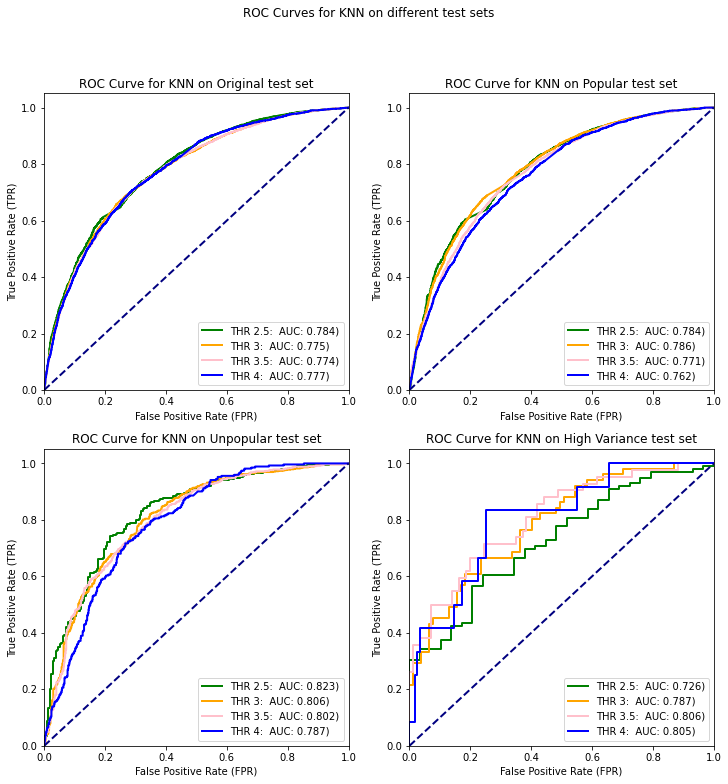

In [371]:
thresholds = [2.5, 3, 3.5, 4]
chosen_k = 20  # to do correct this later

multiple_rocs(data=ratings_data,
              model_type='KNN', 
              trim_types = [None, 'popular','unpopular','high_variance'],
              chosen_k=chosen_k, 
              thresholds=thresholds,
              suptitle='ROC Curves for KNN on different test sets')

TODO report AUCS

In [ ]:
# TODO generalize the above functions for each model type
# TODO check if ROC curve correctly created?

## 5. Model-based Collaborative Filtering

### Question 7

### Question 8

#### Question 8.A Design NMF- Based Collaborative Filter

Design a NMF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. If NMF takes too long, you can increase the step size. Increasing it too much will result in poorer granularity in your results. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y- axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.


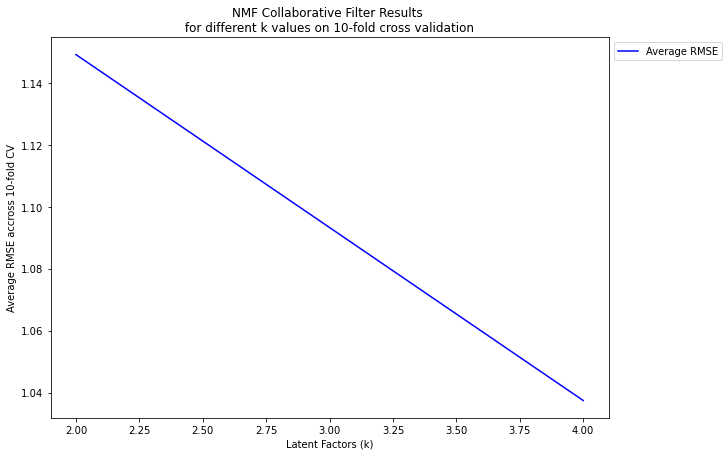

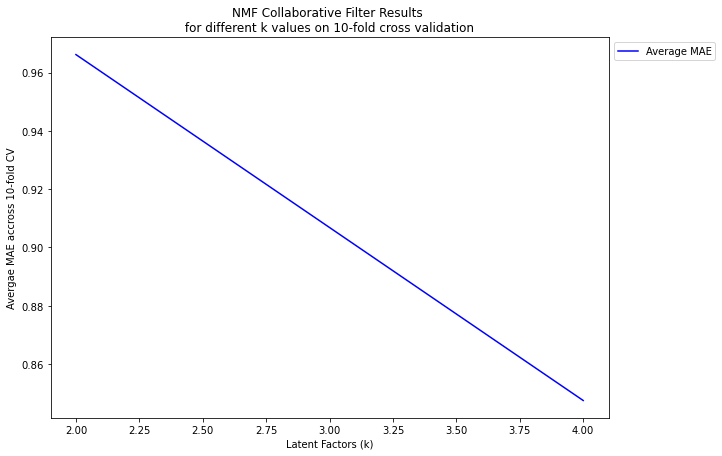

In [82]:
plot_dets_q8 = {
    'x_label': 'Number of Latent Factors (k)',
    'title': 'NMF Collaborative Filter Results \n for different k values on 10-fold cross validation '
}
k_range_q8 = list(range(2, 5, 2))   # to do change range to 50
q8_exp_df = evaluate_model(data=ratings_data, model_type='NMF' ,k_range=k_range_q8, plot_dets=plot_dets_q8)

In [83]:
q8_exp_df.T.head(20)

,0,1
k,2,4
avg_rmse,1.14904,1.03743
avg_mae,0.966169,0.847516
cv_results,"{'test_rmse': [1.1378417825671068, 1.145759940...","{'test_rmse': [1.0347259617704614, 1.036382697..."


#### Question 8.B 

Use the plot from the previous part to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

TODO find optimal k

In [ ]:
# TODO check Is the optimal number of latent factors same as the number of movie genres?

#### Question 8.C

Performance on trimmed Test set subsets: For each of Popular, Unpopular and High- Variance test subsets -
– Design a NMF collaborative filter to predict the ratings of the movies in the trimmed test subset and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds.
– Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.
• Plot the ROC curves for the NMF-based collaborative filter designed in part A for threshold values [2.5, 3, 3.5, 4]. For the ROC plotting use the optimal number of latent factors found in question B. For each of the plots, also report the area under the curve (AUC) value.

##### Results of NMF on Original Test set and Popular, Unpopular, High Variance Trimmed Test Sets

0 / 3 -- k: 2
0 / 3 -- k: 2
0 / 3 -- k: 2
0 / 3 -- k: 2


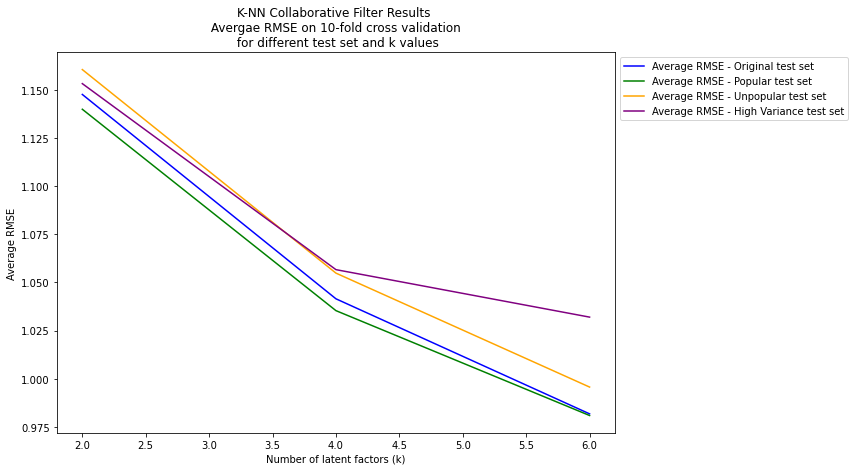

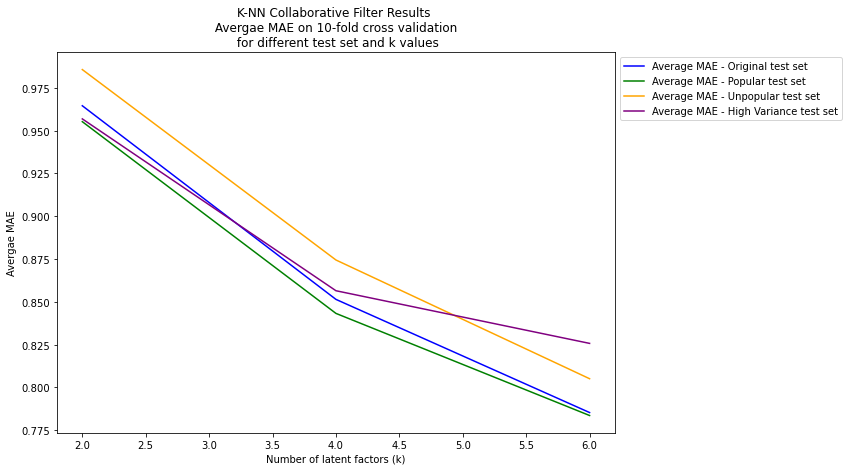

In [84]:
plot_dets_q8 = {
    'x_label': 'Number of latent factors (k)'
}
k_range_q8 = list(range(2, 7, 2))  # to do change range to 50
q8_knn_res_dfs = evaluate_model_on_trimsets(data=ratings_data,
                                                   model_type='NMF',
                                                   k_range=k_range_q8, 
                                                   plot_dets=plot_dets_q8, 
                                                   trim_types = [None, 'popular','unpopular','high_variance'],
                                                   is_plot=True, 
                                                   print_update=True) #TODO make it false later

In [85]:
q8_knn_res_df = pd.concat(q8_knn_res_dfs)
q8_knn_res_df_pivot = q8_knn_res_df.pivot_table(columns='k').T
display(q8_knn_res_df_pivot.head(10))
display(q8_knn_res_df_pivot.describe())
print('Min Avg RMSE and Avg MAE for each test set:')
print(q8_knn_res_df_pivot.min())

,avg_mae_high_variance,avg_mae_original,avg_mae_popular,avg_mae_unpopular,avg_rmse_high_variance,avg_rmse_original,avg_rmse_popular,avg_rmse_unpopular
k,,,,,,,,
2,0.956865,0.964530,0.955237,0.985666,1.153267,1.147644,1.139948,1.160567
4,0.856493,0.851440,0.843255,0.874449,1.056625,1.041472,1.035321,1.054815
6,0.825741,0.785345,0.783618,0.805105,1.031957,0.981700,0.980844,0.995617


,avg_mae_high_variance,avg_mae_original,avg_mae_popular,avg_mae_unpopular,avg_rmse_high_variance,avg_rmse_original,avg_rmse_popular,avg_rmse_unpopular
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.879700,0.867105,0.860703,0.888406,1.080616,1.056939,1.052038,1.070333
std,0.068573,0.090614,0.087130,0.091086,0.064115,0.084046,0.080859,0.083562
min,0.825741,0.785345,0.783618,0.805105,1.031957,0.981700,0.980844,0.995617
25%,0.841117,0.818393,0.813436,0.839777,1.044291,1.011586,1.008083,1.025216
50%,0.856493,0.851440,0.843255,0.874449,1.056625,1.041472,1.035321,1.054815
75%,0.906679,0.907985,0.899246,0.930057,1.104946,1.094558,1.087635,1.107691
max,0.956865,0.964530,0.955237,0.985666,1.153267,1.147644,1.139948,1.160567


Min Avg RMSE and Avg MAE for each test set:
avg_mae_high_variance     0.825741
avg_mae_original          0.785345
avg_mae_popular           0.783618
avg_mae_unpopular         0.805105
avg_rmse_high_variance    1.031957
avg_rmse_original         0.981700
avg_rmse_popular          0.980844
avg_rmse_unpopular        0.995617
dtype: float64


TODO explanation and report min RMSE

##### NMF ROC Curves for each test set

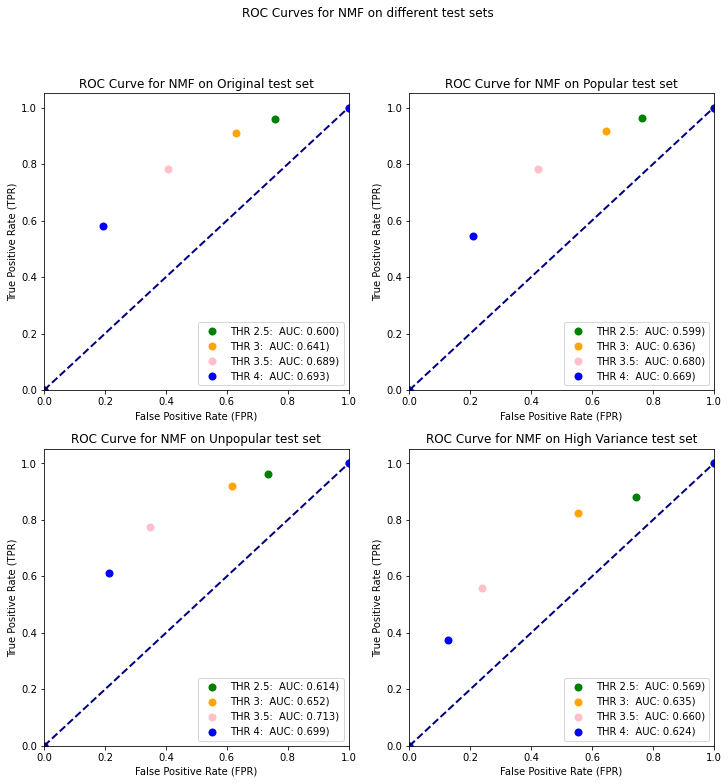

In [86]:
thresholds = [2.5, 3, 3.5, 4]
chosen_k = 12  # to do correct this later

multiple_rocs(data=ratings_data,
              model_type='NMF', 
              trim_types = [None, 'popular','unpopular','high_variance'],
              chosen_k=chosen_k, 
              thresholds=thresholds,
              suptitle='ROC Curves for NMF on different test sets')

TODO report AUCS

### Question 9

Interpreting the NMF model: Perform Non-negative matrix factorization on the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent factors interaction and V represents the movie-latent factors interaction (use k = 20). For each column of V , sort the movies in descending order and report the genres of the top 10 movies. Do the top 10 movies belong to a particular or a small collection of genre? Is there a connection between the latent factors and the movie genres?

In [364]:
# Retrieve the trainset.
whole_train_set = ratings_data.build_full_trainset() # TODO ask if we need to split
q9_k = 20
model_nmf = NMF(n_factors=q9_k, random_state=rand_seed, verbose=0)         
model_nmf.fit(whole_train_set)
U = model_nmf.pu
V = model_nmf.qi

In [365]:
whole_train_set_iids = list(whole_train_set.all_items())
# print(f'pred_set iids are {pred_set_iids}')
iid_converter = lambda x: whole_train_set.to_raw_iid(x)
whole_train_set_raw_iids = list(map(iid_converter, whole_train_set_iids))

V_df = pd.DataFrame(V)
V_df['movId'] =  whole_train_set_raw_iids
V_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,movId
0,0.447124,0.606963,0.278229,0.832767,0.179741,0.022801,0.777665,0.434236,0.865774,0.371291,...,0.523433,0.934755,0.467175,0.431383,0.336084,0.594957,0.459337,0.244243,0.390941,112852
1,0.430486,0.108222,0.035439,0.205902,0.922796,1.236152,0.530992,0.077147,0.191823,0.453131,...,0.832344,0.060312,0.249052,0.637275,0.781580,0.395213,0.500689,0.345827,0.551321,1947
2,0.420501,0.030282,0.593468,0.119453,0.136894,0.166774,0.060199,0.143417,0.043376,0.261782,...,0.267348,0.374297,0.483580,0.301037,0.440614,0.160132,0.316761,0.382887,0.360784,1562
3,0.478775,0.440989,0.523445,0.254507,0.440463,0.539556,0.084055,0.345769,0.688219,0.289270,...,0.132848,0.659976,0.320904,0.718022,0.259715,0.647911,0.387552,0.568249,0.729041,2716
4,0.415930,0.924954,0.325614,0.487063,0.329309,0.620628,0.576291,0.512560,0.199223,0.034173,...,0.471218,0.562448,0.553170,1.011701,0.647172,0.442863,0.427108,0.277184,0.191529,88125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.038682,0.042416,0.175913,0.003962,0.136667,0.079796,0.112758,0.144849,0.133700,0.130702,...,0.110296,0.051497,0.047888,0.041058,0.089850,0.122353,0.075952,0.104970,0.237728,1336
9720,0.049246,0.752715,0.311943,0.387669,0.699237,0.064030,0.275429,0.199173,0.573995,0.313442,...,0.259717,0.380398,0.440161,0.674374,0.136120,0.243927,0.426439,0.383314,0.281016,757
9721,0.226713,0.466703,0.407632,0.379666,0.533507,0.308923,0.004766,0.199700,0.277289,0.226255,...,0.579346,0.296841,0.130493,0.725980,0.334146,0.507489,0.181799,0.370511,0.116303,135534
9722,0.478074,0.427838,0.821465,0.276381,0.470246,0.097337,0.244647,0.743727,0.145223,0.845811,...,0.367959,0.016276,0.750456,0.047448,0.181759,0.643889,0.142946,0.252742,0.193772,7061


In [366]:

col_genres = []
for i in range(q9_k):   
    top_10_movies_for_column = list(V_df.sort_values(by=[i], ascending=False).movId[:10])
    movs = movies.set_index('movieId').loc[top_10_movies_for_column].reset_index(inplace=False)
    col_genres.append(movs.genres.values)
    if i < 4:
        print(f'---- Column {i} top 10 movies genres: ----')
        display(movs)

---- Column 0 top 10 movies genres: ----


,movieId,title,genres
0,70946,Troll 2 (1990),Fantasy|Horror
1,7116,Diabolique (Les diaboliques) (1955),Horror|Mystery|Thriller
2,7564,Kwaidan (Kaidan) (1964),Horror
3,130634,Furious 7 (2015),Action|Crime|Thriller
4,80126,"American, The (2010)",Drama|Thriller
5,2488,Peeping Tom (1960),Drama|Horror|Thriller
6,3223,"Zed & Two Noughts, A (1985)",Drama
7,1173,"Cook the Thief His Wife & Her Lover, The (1989)",Comedy|Drama
8,1606,Kull the Conqueror (1997),Action|Adventure
9,4794,Opera (1987),Crime|Horror|Mystery


---- Column 1 top 10 movies genres: ----


,movieId,title,genres
0,5480,Stuart Little 2 (2002),Children|Comedy
1,305,Ready to Wear (Pret-A-Porter) (1994),Comedy
2,2149,House II: The Second Story (1987),Comedy|Fantasy|Horror
3,32598,Fever Pitch (2005),Comedy|Romance
4,1376,Star Trek IV: The Voyage Home (1986),Adventure|Comedy|Sci-Fi
5,32892,Ivan's Childhood (a.k.a. My Name is Ivan) (Iva...,Drama|War
6,283,New Jersey Drive (1995),Crime|Drama
7,140711,American Ultra (2015),Action|Comedy|Sci-Fi|Thriller
8,54734,Sydney White (2007),Comedy
9,34332,Sky High (2005),Action|Adventure|Children|Comedy


---- Column 2 top 10 movies genres: ----


,movieId,title,genres
0,74754,"Room, The (2003)",Comedy|Drama|Romance
1,4863,Female Trouble (1975),Comedy|Crime
2,93563,Lockout (2012),Action|Sci-Fi|Thriller
3,6380,Capturing the Friedmans (2003),Documentary
4,83827,Marwencol (2010),Documentary
5,1658,"Life Less Ordinary, A (1997)",Romance|Thriller
6,181,Mighty Morphin Power Rangers: The Movie (1995),Action|Children
7,2772,Detroit Rock City (1999),Comedy
8,5296,"Sweetest Thing, The (2002)",Comedy|Romance
9,32892,Ivan's Childhood (a.k.a. My Name is Ivan) (Iva...,Drama|War


---- Column 3 top 10 movies genres: ----


,movieId,title,genres
0,7991,Death Race 2000 (1975),Action|Sci-Fi
1,5919,Android (1982),Sci-Fi
2,26409,"Clonus Horror, The (1979)",Horror|Sci-Fi
3,171867,Rough Night (2017),Comedy|Drama
4,126548,The DUFF (2015),Comedy
5,90888,Immortals (2011),Action|Drama|Fantasy
6,3024,Piranha (1978),Horror|Sci-Fi
7,69644,Ice Age: Dawn of the Dinosaurs (2009),Action|Adventure|Animation|Children|Comedy|Rom...
8,213,Burnt by the Sun (Utomlyonnye solntsem) (1994),Drama
9,2070,Tender Mercies (1983),Drama|Romance|Western


In [367]:
# Top 10 movies' genres for each V column
nmf_genres_per_column = pd.DataFrame(col_genres)
nmf_genres_per_column = nmf_genres_per_column.T
nmf_genres_per_column = nmf_genres_per_column.add_prefix('V_column_')
nmf_genres_per_column = nmf_genres_per_column.T.add_prefix('movie_')
nmf_genres_per_column.T

,V_column_0,V_column_1,V_column_2,V_column_3,V_column_4,V_column_5,V_column_6,V_column_7,V_column_8,V_column_9,V_column_10,V_column_11,V_column_12,V_column_13,V_column_14,V_column_15,V_column_16,V_column_17,V_column_18,V_column_19
movie_0,Fantasy|Horror,Children|Comedy,Comedy|Drama|Romance,Action|Sci-Fi,Action|Fantasy|Horror|Sci-Fi|Thriller,Animation|Children|Comedy|Musical,Children|Comedy|Fantasy|Romance,Action|Adventure|Sci-Fi,Action|Horror|Thriller,Fantasy|Western,Drama,Horror|Thriller,Drama|Sci-Fi,Comedy|Romance,Comedy|Romance,Drama|Fantasy|Mystery,Action|Fantasy|Horror|Sci-Fi|Thriller,Drama,Drama|Romance,Action|Comedy|Western
movie_1,Horror|Mystery|Thriller,Comedy,Comedy|Crime,Sci-Fi,Comedy|Romance,Adventure|Animation|Children|Comedy|IMAX,Action|Adventure|Animation,Drama|Romance,Children|Comedy,Comedy|Romance,Drama|Thriller,Animation|Comedy,Crime|Drama|Fantasy|Mystery|Thriller,Drama|Romance,Drama,Sci-Fi,Drama,Comedy,Comedy|Drama,Action|Adventure|Drama|Thriller
movie_2,Horror,Comedy|Fantasy|Horror,Action|Sci-Fi|Thriller,Horror|Sci-Fi,Drama,Horror|Thriller,Action|Comedy|Crime|Fantasy,Documentary,Comedy,Action|Crime|Sci-Fi|Thriller,Fantasy|Horror,Comedy|Drama,Horror|Thriller,Comedy|Horror,Crime|Horror|Mystery,Comedy|Drama,Horror,Comedy,Sci-Fi,Comedy|Documentary
movie_3,Action|Crime|Thriller,Comedy|Romance,Documentary,Comedy|Drama,Drama|Horror|Thriller,Comedy|Romance,Comedy|Drama,Action|Drama,Comedy,Adventure|Children,Drama|Romance|Thriller,Comedy|Drama|Romance,Comedy,Drama|Film-Noir,Drama,Drama|Thriller,Comedy|Drama,Action|Comedy|Sci-Fi,Drama|Romance|Thriller,Comedy
movie_4,Drama|Thriller,Adventure|Comedy|Sci-Fi,Documentary,Comedy,Action|Drama,Animation|Children|Comedy,Children|Comedy|Drama,Animation|Comedy,Comedy,Action|Adventure|Children|Fantasy,Comedy|Crime|Mystery|Romance,Adventure|Drama,Comedy,Action|Adventure|Animation|Children|Comedy,Horror|Mystery|Thriller,Drama|Romance,Crime|Drama|War,Adventure|Children|Comedy,Action|Sci-Fi,Comedy
movie_5,Drama|Horror|Thriller,Drama|War,Romance|Thriller,Action|Drama|Fantasy,Comedy|Fantasy,Horror,Comedy,Drama|Mystery,Drama|Romance,Comedy|Drama,Action|Adventure|Fantasy|Sci-Fi,Drama|War,Comedy|Drama,Horror|Thriller,Drama,Action|Drama|Fantasy,Animation|Comedy|Drama|Fantasy|Sci-Fi,Action|Sci-Fi|Thriller,Action|Comedy,Comedy
movie_6,Drama,Crime|Drama,Action|Children,Horror|Sci-Fi,Thriller,Action|Comedy|Crime,Action|Comedy|Crime|Thriller,Comedy|Fantasy|Horror|Musical|Thriller,Action|Adventure|Animation|Fantasy,Comedy,Drama|Mystery|Romance,Drama|Horror,Action|Drama,Comedy,Comedy|Drama|Horror,Comedy|Drama|Horror,Drama|Sci-Fi,Action|Sci-Fi,Drama|Thriller,Action|Drama|Sci-Fi
movie_7,Comedy|Drama,Action|Comedy|Sci-Fi|Thriller,Comedy,Action|Adventure|Animation|Children|Comedy|Rom...,Horror|Sci-Fi|Thriller,Comedy|Drama|Romance,Drama,Comedy|Romance,Fantasy|Romance|Thriller|IMAX,Drama|Mystery|Sci-Fi,Action|Adventure|Sci-Fi,Action|Adventure|Sci-Fi|Thriller,Drama,Adventure|Thriller,Drama|Thriller,Drama|Mystery|Sci-Fi,Action|Drama,Crime|Drama|Romance,Action|Comedy|Drama,Comedy
movie_8,Action|Adventure,Comedy,Comedy|Romance,Drama,Comedy|Documentary,Action|Comedy,Action|Comedy,Comedy|Drama|Romance,Horror,Children|Comedy|Fantasy,Horror,Crime|Drama,Horror|Thriller,Drama|Fantasy|Romance,Comedy|Horror,Comedy|Romance,Comedy,Comedy|Musical,Drama,Comedy|Romance
movie_9,Crime|Horror|Mystery,Action|Adventure|Children|Comedy,Drama|War,Drama|Romance|Western,Comedy|Crime,Comedy|Drama,Horror|Mystery,Drama|Romance,Adventure|Drama,Comedy|Drama,Action|Crime|Thriller,Drama|Horror|Thriller,Comedy,Crime|Drama|Mystery,Drama|Romance,Comedy|Romance,Drama,Drama|Romance,Comedy|Documentary,Comedy|Fantasy|Romance


TODO answer:
__Do the top 10 movies belong to a particular or a small collection of genre?__
Yes,

__Is there a connection between the latent factors and the movie genres?__



### Question 10

#### Question 10.A Design MF with bias Collaborative Filter

Design a MF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.

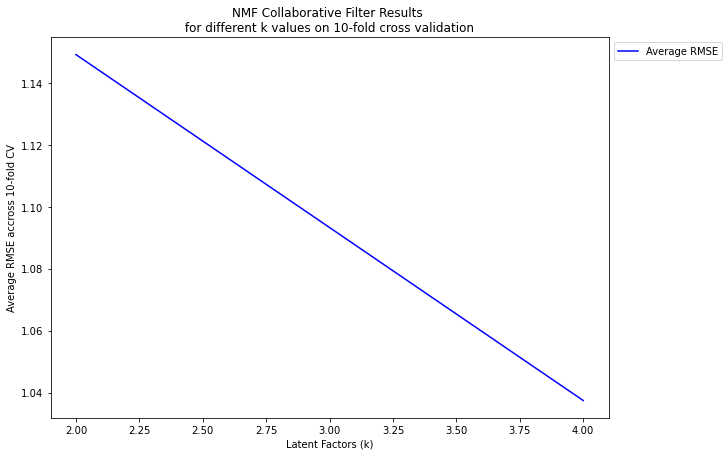

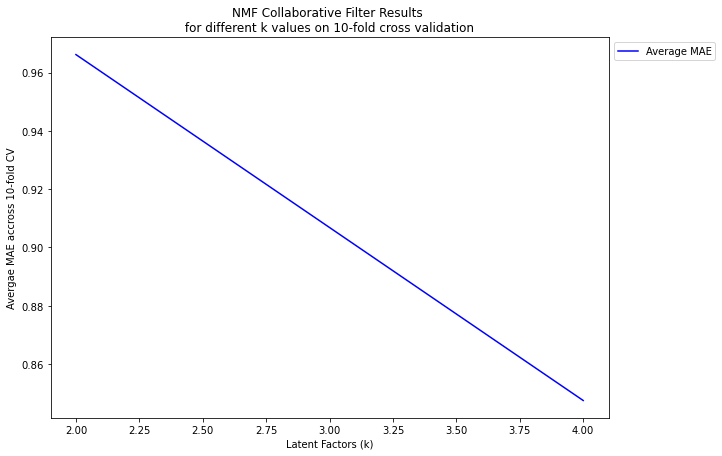

In [82]:
plot_dets_q10 = {
    'x_label': 'Number of Latent Factors (k)',
    'title': 'MF with bias Collaborative Filter Results \n for different k values on 10-fold cross validation '
}
k_range_q10 = list(range(2, 5, 2))   # to do change range to 50
q10_exp_df = evaluate_model(data=ratings_data, model_type='MF' ,k_range=k_range_q10, plot_dets=plot_dets_q10)

In [83]:
q10_exp_df.T.head(20)

,0,1
k,2,4
avg_rmse,1.14904,1.03743
avg_mae,0.966169,0.847516
cv_results,"{'test_rmse': [1.1378417825671068, 1.145759940...","{'test_rmse': [1.0347259617704614, 1.036382697..."


#### Question 10.B 

Use the plot from the previous part to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

TODO find optimal k

In [ ]:
# TODO check Is the optimal number of latent factors same as the number of movie genres?

#### Question 10.C

Performance on Test set subsets: For each of Popular, Unpopular and High-Variance test subsets 

-  Design a MF collaborative filter to predict the ratings of the movies in the trimmed test subset and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds.
-  Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.

Plot the ROC curves for the NMF-based collaborative filter designed in part A for threshold values [2.5, 3, 3.5, 4]. For the ROC plotting use the optimal number of latent factors found in question B. For each of the plots, also report the area under the curve (AUC) value.

##### Results of MF with bias on Original Test set and Popular, Unpopular, High Variance Trimmed Test Sets

0 / 3 -- k: 2
0 / 3 -- k: 2
0 / 3 -- k: 2
0 / 3 -- k: 2


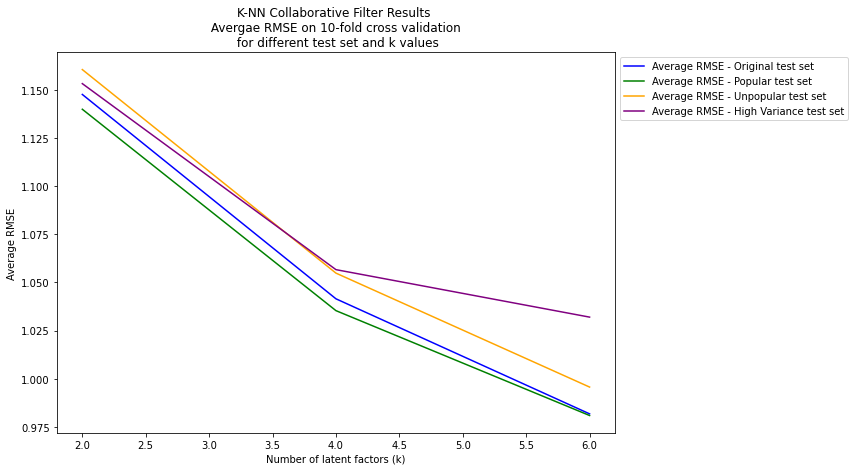

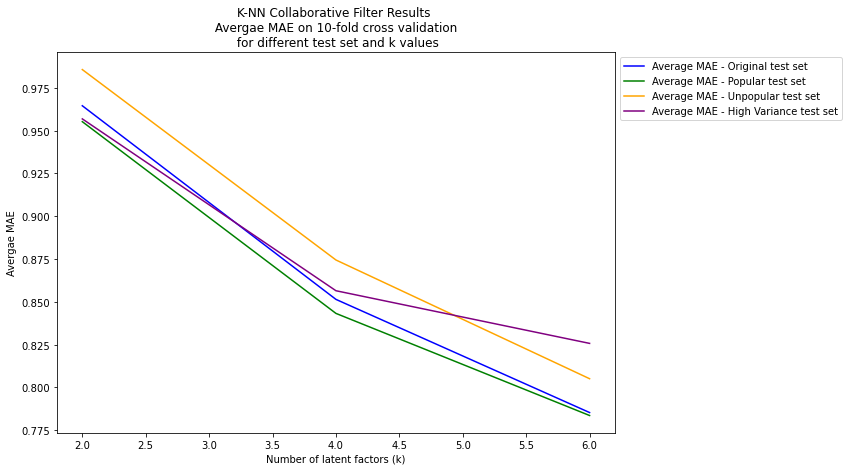

In [84]:
plot_dets_q10 = {
    'x_label': 'Number of latent factors (k)'
}
k_range_q10 = list(range(2, 7, 2))  # to do change range to 50
q10_mf_res_dfs = evaluate_model_on_trimsets(data=ratings_data,
                                                   model_type='MF',
                                                   k_range=k_range_q10, 
                                                   plot_dets=plot_dets_q10, 
                                                   trim_types = [None, 'popular','unpopular','high_variance'],
                                                   is_plot=True, 
                                                   print_update=True) #TODO make it false later

In [85]:
q10_mf_res_dfs = pd.concat(q8_knn_res_dfs)
q10_mf_res_df_pivot = q10_mf_res_dfs.pivot_table(columns='k').T
display(q10_mf_res_df_pivot.head(10))
display(q10_mf_res_df_pivot.describe())
print('Min Avg RMSE and Avg MAE for each test set:')
print(q10_mf_res_df_pivot.min())

,avg_mae_high_variance,avg_mae_original,avg_mae_popular,avg_mae_unpopular,avg_rmse_high_variance,avg_rmse_original,avg_rmse_popular,avg_rmse_unpopular
k,,,,,,,,
2,0.956865,0.964530,0.955237,0.985666,1.153267,1.147644,1.139948,1.160567
4,0.856493,0.851440,0.843255,0.874449,1.056625,1.041472,1.035321,1.054815
6,0.825741,0.785345,0.783618,0.805105,1.031957,0.981700,0.980844,0.995617


,avg_mae_high_variance,avg_mae_original,avg_mae_popular,avg_mae_unpopular,avg_rmse_high_variance,avg_rmse_original,avg_rmse_popular,avg_rmse_unpopular
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.879700,0.867105,0.860703,0.888406,1.080616,1.056939,1.052038,1.070333
std,0.068573,0.090614,0.087130,0.091086,0.064115,0.084046,0.080859,0.083562
min,0.825741,0.785345,0.783618,0.805105,1.031957,0.981700,0.980844,0.995617
25%,0.841117,0.818393,0.813436,0.839777,1.044291,1.011586,1.008083,1.025216
50%,0.856493,0.851440,0.843255,0.874449,1.056625,1.041472,1.035321,1.054815
75%,0.906679,0.907985,0.899246,0.930057,1.104946,1.094558,1.087635,1.107691
max,0.956865,0.964530,0.955237,0.985666,1.153267,1.147644,1.139948,1.160567


Min Avg RMSE and Avg MAE for each test set:
avg_mae_high_variance     0.825741
avg_mae_original          0.785345
avg_mae_popular           0.783618
avg_mae_unpopular         0.805105
avg_rmse_high_variance    1.031957
avg_rmse_original         0.981700
avg_rmse_popular          0.980844
avg_rmse_unpopular        0.995617
dtype: float64


TODO explanation and report min RMSE

##### MF ROC Curves for each test set

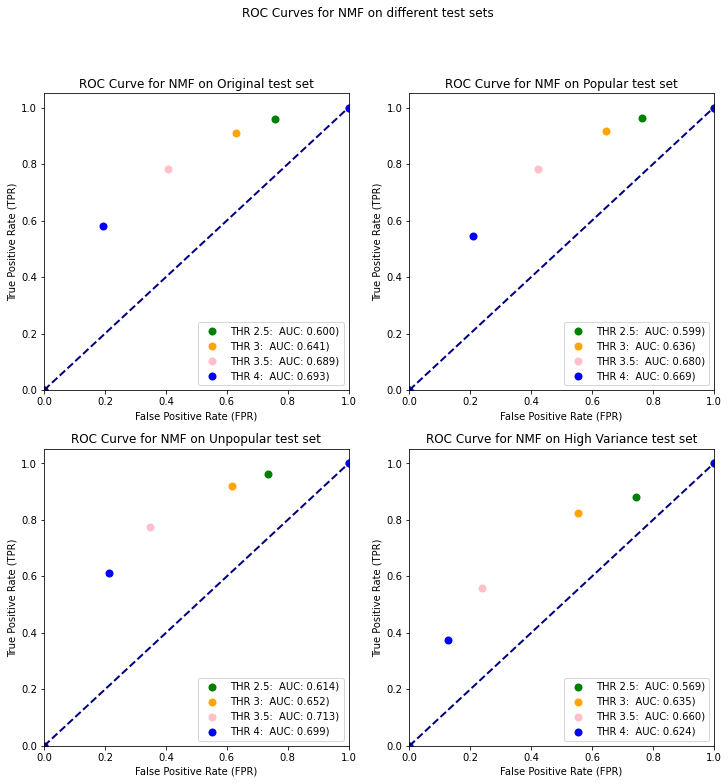

In [86]:
thresholds = [2.5, 3, 3.5, 4]
chosen_k_q10 = 12  # to do correct this later

multiple_rocs(data=ratings_data,
              model_type='MF', 
              trim_types = [None, 'popular','unpopular','high_variance'],
              chosen_k=chosen_k_q10, 
              thresholds=thresholds,
              suptitle='ROC Curves for MF on different test sets')

TODO report AUCS

## 6. Naive collaborative filtering

### Question 11

__Designing a Naive Collaborative Filter:__

- Design a naive collaborative filter to predict the ratings of the movies in the original dataset
and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by
averaging the RMSE across all 10 folds. Report the average RMSE.
Note that in this case, when performing the cross-validation, there is no need to calculate μ ’s i
for the training folds each time. You are only asked to use a single set of μ ’s calculated on i
the entire dataset and validate on 10 validation folds.
- Performance on Test set subsets: For each of Popular, Unpopular and High-Variance test subsets -
    - Design a naive collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it’s performance using 10-fold cross validation.
    - Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

In [301]:
# Naive Collaborative Filter
ratings_per_user = pd.DataFrame(ratings_raw.groupby(by='userId').agg(mean_rating=('rating', 'mean'))).reset_index()
ratings_per_user.head(10).T

,0,1,2,3,4,5,6,7,8,9
userId,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.00000,10.000000
mean_rating,4.368534,3.948276,2.435897,3.555556,3.636364,3.493631,3.230263,3.574468,3.26087,3.278571


In [312]:
def get_naive_predictions_from_test(ratings_per_user, test_set):
    preds = []
    for t in test_set:
        preds.append(ratings_per_user[ratings_per_user.userId==t[0] ].mean_rating.values[0])
    return preds

def perform_naive_cf(data, ratings_per_user, test_type=None):
    rmses, maes = [],[]
    kf = KFold(n_splits=10)
    for train_set, test_set in kf.split(data):
        if not test_type:
            trimmed_test= test_set
        else:
            trimmed_test = clean_based_on_trim_type(data=test_set, trim_type=test_type)
    
        preds = get_naive_predictions_from_test(ratings_per_user, trimmed_test)
        y_true = [t[2] for t in trimmed_test]
        rmses.append(mean_squared_error(y_true, preds, squared=False)) # squared false returns RMSE
        maes.append(mean_absolute_error(y_true, preds))
    avg_rmse = np.mean(rmses)
    avg_mae = np.mean(maes)
    if not test_type:
        test_type='original'
    print(f'Naive Collaborative Filter on {test_type.capitalize()} Average RMSE: {avg_rmse}')
    print(f'Naive Collaborative Filter on {test_type.capitalize()} Average MAE: {avg_mae}')
    return rmses, maes

In [313]:
rmses, maes = perform_naive_cf(data=ratings_data, ratings_per_user=ratings_per_user)

Naive Collaborative Filter on Original Average RMSE: 0.9347006383550307
Naive Collaborative Filter on Original Average MAE: 0.7289330232563683


In [315]:
for trim_t in ['popular', 'unpopular', 'high_variance']:
    rmses, maes = perform_naive_cf(data=ratings_data, 
                                   ratings_per_user=ratings_per_user,
                                   test_type=trim_t)

Naive Collaborative Filter on Popular Average RMSE: 0.9250697299592783
Naive Collaborative Filter on Popular Average MAE: 0.7214352508500219
Naive Collaborative Filter on Unpopular Average RMSE: 0.970401034873977
Naive Collaborative Filter on Unpopular Average MAE: 0.7558436858474529
Naive Collaborative Filter on High_variance Average RMSE: 0.9257259171647648
Naive Collaborative Filter on High_variance Average MAE: 0.7211466018055619


TODO comment

## 7. Performance Comparison

### Question 12

Comparing the most performant models across architecture: Plot the best ROC curves (threshold = 3) for the k-NN, NMF, and MF with bias based collaborative filters in the same figure. Use the figure to compare the performance of the filters in predicting the ratings of the movies.

In [ ]:
fprs, tprs, auc_scores = plot_performant_model_roc_curves(data, model_types, chosen_ks, thrs)      

In [374]:
def plot_performant_model_roc_curves(data, model_types, chosen_ks, threshold):
    train_data, test_data = train_test_split(data, test_size=0.1)
    fprs, tprs, auc_scores = [],[],[]
    for model_t, k in  zip(model_types, chosen_ks):
        model = get_model(model_type=model_t, k=k)
        model.fit(train_data)
        preds = model.test(test_data)

        preds_vals = [pred.est for pred in preds]
        #preds_vals_thresholded = [1 if pred.est > threshold else 0 for pred in preds ]
        ground_truth_thresholded = [1 if pred.r_ui > threshold else 0 for pred in preds ]

        fpr, tpr, ths = roc_curve(y_true=ground_truth_thresholded, y_score=preds_vals)
        auc_score_res = auc(fpr, tpr)
        fprs.append(fpr)
        tprs.append(tpr)
        auc_scores.append(auc_score_res)

    plot_roc2(fprs=fprs, tprs=tprs, thresholds=threshold, aucs=auc_scores, 
              model_types=model_types, chosen_ks=chosen_ks, 
              title=f'ROC Curves for Performant Models \n threshod: {threshold}')

    return fprs, tprs, auc_scores

def plot_roc2(fprs, tprs, thresholds, aucs, model_types, chosen_ks, title=''):
    lw = 1
    colors = ['green', 'orange','pink']
    
    plt.figure(figsize=(7,7))
    for i in range(len(model_types)):
        plt.plot(
            fprs[i],
            tprs[i],
            color=colors[i],
            lw=lw,
            label=f"THR {model_types[i]} - k: {chosen_ks[i]}:  AUC: {aucs[i]:.3f})",
        )


    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(title)
    plt.legend(loc="lower right")
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.show()
  

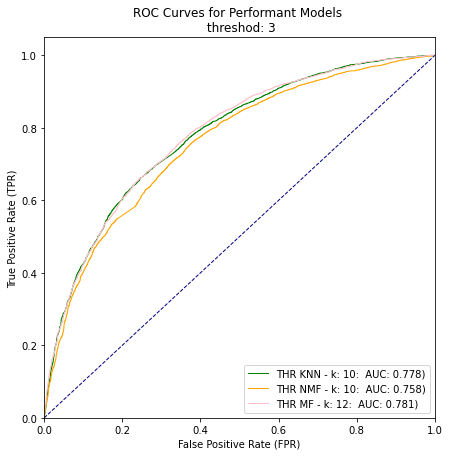

In [375]:
fprs, tprs, auc_scores = plot_performant_model_roc_curves(data=ratings_data, 
                                                           model_types=['KNN','NMF','MF'], 
                                                           chosen_ks=[10,10,12],    #TODO put the right values later
                                                           threshold=3)

TODO write comparison

## 8. Ranking

### Question 13

Understanding Precision and Recall in the context of Recommender Systems: Precision and Recall are defined by the mathematical expressions given by equations 12 and 13 respectively. Please explain the meaning of precision and recall in your own words.


Precision: What rate of the recommended items list is also liked by the user


Recall: What rate of likes movies by the user is in recommmended items list.

In [358]:
# TODO improve explanation

### Question 14

Understanding Precision and Recall in the context of Recommender Systems: Precision and Recall are defined by the mathematical expressions given by equations 12 and 13 respectively. Please explain the meaning of precision and recall in your own words.

In [ ]:
# TODO mention unbiased variance in all qs

In [544]:
ratings_data

In [556]:
train_data, test_data = train_test_split(ratings_data, test_size=0.1)
model = get_model(model_type='KNN', k=20)
model.fit(train_data)
preds = model.test(test_data)

thr = 3
pred_df = pd.DataFrame(preds)
pred_df['G']= pred_df.r_ui > thr
pred_df.G = pred_df.G.astype(int)

# If |G| = 0 for some user in the test set, then drop this user, user didn't like any items in this test set
uid_G_count = pd.DataFrame(pred_df.groupby('uid').G.sum()).reset_index()
uid_G_count.rename(columns={'G':'G_sum'}, inplace=True)
drop_users_lenG_0 = uid_G_count[uid_G_count.G_sum==0].uid.values

# If some user in the test set has rated less than t items, then drop this user
t = 2
uid_rating_count = pd.DataFrame(pred_df.groupby('uid').r_ui.count()).reset_index()
uid_rating_count.rename(columns={'r_ui':'rating_count'}, inplace=True)
uid_rating_count_drop = uid_rating_count[uid_rating_count.rating_count < t].uid.values

print(pred_df.shape)
pred_df_cleaned = pred_df[(~pred_df.uid.isin(uid_rating_count_drop)) & (~pred_df.uid.isin(drop_users_lenG_0))]
print(pred_df_cleaned.shape)

# G: The set of items liked by the user (ground-truth positives)
G_df = pred_df_cleaned[pred_df_cleaned.G ==1]
G_df_list = G_df.groupby('uid')['iid'].apply(list).reset_index(name='liked_items')

# S(t) : The set of items of size t recommended to the user. In this recommended set, ignore
# (drop) the items for which we don’t have a ground truth rating.
pred_df_cleaned = pred_df_cleaned.sort_values(by=['uid', 'est'], ascending=[True,False])
S_list = pred_df_cleaned.groupby('uid')['iid'].apply(list).reset_index(name='rec_order_items')
S_list['rec_t_items'] = S_list.rec_order_items.apply(lambda x: x[:t])

uid_res = pd.merge(S_list, G_df_list)
uid_res['user_precision'] = uid_res.apply(lambda x: len(set(x[2]).intersection(set(x[3])))/float(len(x[2])) ,axis=1)
uid_res['user_recall'] = uid_res.apply(lambda x: len(set(x[2]).intersection(set(x[3])))/float(len(x[3])) ,axis=1)

display(uid_res)
avg_user_prec = np.mean(uid_res['user_precision'])
avg_user_recall = np.mean(uid_res['user_recall'])
print(avg_user_prec, avg_user_recall)

(10084, 6)
(10024, 6)


,uid,rec_order_items,rec_t_items,liked_items,user_precision,user_recall
0,1,"[1196, 1080, 1278, 1226, 441, 1210, 3448, 1258...","[1196, 1080]","[2353, 1210, 151, 3448, 2797, 2012, 441, 1278,...",1.0,0.080000
1,2,"[80906, 109487, 114060]","[80906, 109487]",[80906],0.5,1.000000
2,3,"[3703, 72378]","[3703, 72378]",[3703],0.5,1.000000
3,4,"[2583, 1197, 2186, 1304, 914, 1103, 1213, 1617...","[2583, 1197]","[1203, 3160, 4121, 457, 1084, 1197, 1500, 1213...",1.0,0.111111
4,5,"[296, 349, 21, 153]","[296, 349]","[296, 21]",0.5,0.500000
...,...,...,...,...,...,...
554,606,"[750, 1066, 2732, 1949, 3306, 475, 2997, 541, ...","[750, 1066]","[927, 7018, 7396, 27627, 45517, 4979, 60069, 3...",1.0,0.020000
555,607,"[3147, 1214, 1079, 188, 3020, 1036, 337, 2313,...","[3147, 1214]","[2313, 949, 3273, 3499, 2710, 2881, 1625, 3020...",0.5,0.062500
556,608,"[430, 2550, 608, 5618, 3996, 5072, 1997, 2329,...","[430, 2550]","[2329, 1961, 27839, 5219, 733, 4975, 4963, 561...",0.0,0.000000
557,609,"[356, 137, 480, 434, 1056, 185, 613, 833]","[356, 137]",[356],0.5,1.000000


0.7754919499105546 0.3731635284202282


In [ ]:
def get_prec_recall(preds):
    
    
    
    
    return precision, recall

def evaluate_precision_recall_on_models(data, model_types, k_range, plot_dets, threshold=3, is_plot=True, print_update=False):
 
    kf = KFold(n_splits=10)
    all_precs, all_recalls, res_dfs = [],[], []
    for model_type in model_types:
        avg_prec_model, avg_recall_model = [], []
        cv_results_dict = {}
        
        for i, k in enumerate(k_range):
            if i % 10==0 and print_update:   # TODO fix later
                    print(f'{i} / {len(k_range)} -- k: {k}')

            avg_prec_fold, avg_recall_fold = [], []
            for train_data, test_data in kf.split(data):
                
                model = get_model(model_type=model_type, k=k) 
                model.fit(train_data)
                preds = model.test(test_data)
                
                # calculate precision and recall 
                precision, recall = get_prec_recall(preds)
                
                avg_prec_fold.append(precision))
                avg_recall_fold.append(recall)

            cv_results_dict[k]={'rmse_results':k_rmses, 'mae_results':k_maes}    
            avg_prec_model.append(np.mean(avg_prec_fold))
            avg_recall_model.append(np.mean(avg_recall_fold))
        trim_type_name = trim_type if trim_type else 'original'
        res_df = pd.DataFrame({'k': k_range, f'avg_precision_{model_type}':avg_prec_model, f'avg_recall_{model_type}':avg_recall_model}) #, 'cv_results':[cv_results_dict]})
        res_dfs.append(res_df)
        all_precs.append(avg_prec_model)
        all_recalls.append(avg_recall_model)
         
    if is_plot: 
        title = f'K-NN Collaborative Filter Results \n for different test set and k values \n on 10-fold cross validation '
        trim_names = []
        for trim_type in trim_types:
            trim_name=None
            if not trim_type:
                trim_name = 'Original'
            elif trim_type=='high_variance':
                trim_name = 'High Variance'
            else:
                trim_name = trim_type.capitalize()
            trim_names.append(trim_name)
        plot_evaluation_metric(x= k_range, 
                               ys=all_rmses,
                               x_label=plot_dets['x_label'],
                               y_label='Average RMSE',
                               title=f'K-NN Collaborative Filter Results \n Avergae RMSE on 10-fold cross validation \n for different test set and k values', 
                               labels=[f'Average RMSE - {x} test set' for x in trim_names])
        plot_evaluation_metric(x= k_range, 
                               ys=all_maes,
                               x_label=plot_dets['x_label'],
                               y_label='Avergae MAE',
                               title=f'K-NN Collaborative Filter Results \n Avergae MAE on 10-fold cross validation \n for different test set and k values', 
                               labels=[f'Average MAE - {x} test set' for x in trim_names])
       
    return res_dfs
    

In [478]:
# Understaindg Impossible Prediction Rate
counts= []
ratios = []
for i in range(4):
    train_data, test_data = train_test_split(ratings_data, test_size=0.1)
    model = get_model(model_type='KNN', k=20)
    model.fit(train_data)
    preds = model.test(test_data)

    count = 0
    for pred in preds:
        if 'reason' in pred[4].keys() and pred[4]['reason']=='User and/or item is unknown.':

            count+=1
    counts.append(count)
    ratios.append(count/len(preds))

pd.DataFrame(ratios).describe().T

,count,mean,std,min,25%,50%,75%,max
0,4.0,0.035626,0.001485,0.033717,0.034832,0.035898,0.036692,0.036989
